### Start importing all libraries

In [1]:
# Global
import numpy as np
import tqdm

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf

from fastPTA.priors import Priors
from fastPTA.signals import get_signal_model
from fastPTA.Fisher_code import compute_fisher
from fastPTA.MCMC_code import run_MCMC

### Constants to be used in the analysis

In [2]:
# Total observation time in years
T_obs_yrs = 10.0  # 6.03

# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars in the analysis
n_pulsars = 100

# Specify the type of noise to be used in the analysis
which_experiment = eu.mockSKA10

# Set the label to specify the signal model
signal_label = "power_law_SIGW"

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude of the power law
tilt = 2.0  # Tilt of the power law
SIGW_log_amplitude = -2  # log amplitude SIGW
SIGW_log_width = np.log10(0.5)  # log width SIGW
SIGW_log_pivot = -8.45  # log pivot SIGW

# Specify the true signal parameters
signal_parameters = np.array(
    [log_amplitude, tilt, SIGW_log_amplitude, SIGW_log_width, SIGW_log_pivot]
)

# Specify the labels for the signal parameters
parameter_labels = []

# Specify the priors for the signal parameters (should be a dictionary, the
# parameter names are the keys and the values are the dictionaries with the
# prior information) if not specfied here will build from fisher results
priors_dictionary = {}

# Number of points to generate for the Fisher
len_fisher_data = int(1e4)

# Name of the pulsar catalogue
outname = "pulsar_configurations/SKA200p.txt"

### Some inputs for the MCMC

In [3]:
# Whether the MCMC should be rerun
rerun_MCMC = True

# Whether the MCMC data should be regenerated
regenerate_MCMC_data = True

# Whether to generate a data realization or take data at face value
realization = False

# Number of burnin steps for the MCMC
burnin_steps_default = 100

# Maximum number of iterations to get R close to 1
i_max_default = 100

# Accepted value for the Gellman-Rubin convergence criterion
R_convergence_default = 1e-1

# Criterion to be used for the convergence of the MCMC chains
R_criterion_default = "mean_squared"

# Number of MCMC steps in each iteration
MCMC_iteration_steps_default = 300

# Path to the MCMC_data
path_to_MCMC_data = "generated_data/MCMC_data_Pl+SIGW_200p.npz"

# Path to the MCMC chains
path_to_MCMC_chains = "generated_chains/MCMC_chains_Pl+SIGW_200p.npz"

### Set the inputs for the Fisher and MCMC analysis

In [4]:
# Get the signal model
signal_model = get_signal_model(signal_label)

# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": True,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "regenerate_catalog": True,
    "path_to_pulsar_catalog": outname,
}

# Dictionary with the kwargs for the Fisher matrix
fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": signal_parameters,
}

# Dictionary with the kwargs for the MCMC
MCMC_kwargs = {
    "regenerate_MCMC_data": regenerate_MCMC_data,
    "realization": realization,
    "path_to_MCMC_data": path_to_MCMC_data,
    "path_to_MCMC_chains": path_to_MCMC_chains,
    "i_max": i_max_default,
    "R_convergence": R_convergence_default,
    "R_criterion": R_criterion_default,
    "burnin_steps": burnin_steps_default,
    "MCMC_iteration_steps": MCMC_iteration_steps_default,
}

### Prepare the model to scan over

In [5]:
if "regenerate_catalog" in get_tensors_kwargs.keys():
    if get_tensors_kwargs["regenerate_catalog"]:
        rerun_MCMC = True

(
    frequency,
    signal_value,
    HD_functions_IJ,
    HD_coeffs,
    effective_noise,
    SNR,
    fisher,
) = compute_fisher(
    **fisher_kwargs,
    get_tensors_kwargs=get_tensors_kwargs,
    generate_catalog_kwargs=generate_catalog_kwargs,
)

covariance = ut.compute_inverse(fisher)
fisher_data = np.random.multivariate_normal(
    signal_parameters, covariance, size=len_fisher_data
)
errors = np.sqrt(np.diag(covariance))
print("Fisher errors", errors)

fisher_ranges = np.vstack(
    (signal_parameters - 5 * errors, signal_parameters + 5 * errors)
)

get_tensors_kwargs["regenerate_catalog"] = False

Fisher errors [0.02205475 0.09323647 1.56807084 2.75769828 0.47715658]


In [6]:
to_keep = []

for i in tqdm.tqdm(range(len(fisher_data))):

    PBH_abundance = signal_model.get_PBH_abundance(fisher_data[i])

    if PBH_abundance > 1 or np.isnan(PBH_abundance):
        to_keep.append(False)

    else:
        to_keep.append(True)

fisher_reject = fisher_data[to_keep]

100%|██████████| 10000/10000 [00:27<00:00, 360.83it/s]


In [7]:
mean = np.mean(fisher_reject, axis=0)
std = np.std(fisher_reject, axis=0)

In [14]:
parameter_names = signal_model.parameter_names

ndims = len(parameter_names)
nwalkers = max(2 * ndims, 5)
initial = np.empty((nwalkers, ndims))

mins = np.array([s * 0.95 if s > 0 else s * 1.05 for s in signal_parameters])
maxs = np.array([s * 1.05 if s > 0 else s * 0.95 for s in signal_parameters])

i = 0
while i < nwalkers:
    new = np.random.uniform(mins, maxs)
    
    PBH_abundance = signal_model.get_PBH_abundance(new)

    if PBH_abundance > 1 or np.isnan(PBH_abundance):
        pass  # Do nothing
    else:
        initial[i] = new
        i += 1

In [9]:
# If the priors dictionary is empty, build it from the Fisher results
if True:  # not priors_dictionary:

    mins = np.array([s * 0.9 if s > 0 else s * 1.1 for s in signal_parameters])
    maxs = np.array([s * 1.1 if s > 0 else s * 0.9 for s in signal_parameters])

    parameter_names = signal_model.parameter_names
    diffs = np.abs(np.diff(fisher_ranges, axis=0).squeeze())

    for i in range(len(parameter_names)):

        if i < 2:
            priors_dictionary[parameter_names[i]] = {
                "uniform": {"loc": fisher_ranges[0, i], "scale": diffs[i]}
            }

        else:
            priors_dictionary[parameter_names[i]] = {
                "uniform": {"loc": -10.0, "scale": 10.0}
            }

priors_dictionary["log_amplitude_scalar"] = {
    "uniform": {"loc": -4.0, "scale": 4.0}
}
priors_dictionary["log_width"] = {"uniform": {"loc": -3, "scale": 4}}
priors_dictionary["log_pivot"] = {"uniform": {"loc": -10.0, "scale": 3.}}

priors = Priors(
    priors_dictionary, get_PBH_abundance=signal_model.get_PBH_abundance, check_PBH_abundance=False,
)

In [10]:
print(priors.priors)

{'log_amplitude_PL': {'pdf': <bound method rv_continuous.pdf of <scipy.stats._continuous_distns.uniform_gen object at 0x7bfd1d1c7cd0>>, 'rvs': <bound method rv_generic.rvs of <scipy.stats._continuous_distns.uniform_gen object at 0x7bfd1d1c7cd0>>, 'pdf_kwargs': {'loc': np.float64(-7.309773770242445), 'scale': np.float64(0.22054754048489045)}}, 'tilt': {'pdf': <bound method rv_continuous.pdf of <scipy.stats._continuous_distns.uniform_gen object at 0x7bfd1d1c7cd0>>, 'rvs': <bound method rv_generic.rvs of <scipy.stats._continuous_distns.uniform_gen object at 0x7bfd1d1c7cd0>>, 'pdf_kwargs': {'loc': np.float64(1.5338176537865669), 'scale': np.float64(0.9323646924268665)}}, 'log_amplitude_scalar': {'pdf': <bound method rv_continuous.pdf of <scipy.stats._continuous_distns.uniform_gen object at 0x7bfd1d1c7cd0>>, 'rvs': <bound method rv_generic.rvs of <scipy.stats._continuous_distns.uniform_gen object at 0x7bfd1d1c7cd0>>, 'pdf_kwargs': {'loc': -4.0, 'scale': 4.0}}, 'log_width': {'pdf': <bound me

In [11]:
try:
    if rerun_MCMC:
        raise FileNotFoundError("Flag forces MCMC chains regeneration")

    MCMC_results = np.load(path_to_MCMC_chains)
    MCMC_data = MCMC_results["samples"]
    pdfs = MCMC_results["pdfs"]

except FileNotFoundError:
    MCMC_data, pdfs = run_MCMC(
        priors,
        initial=initial,
        **fisher_kwargs,
        **MCMC_kwargs,
        get_tensors_kwargs=get_tensors_kwargs,
    )


Regenerating MCMC data
- Data will use the expectation value

Initial run


  0%|          | 0/100 [00:00<?, ?it/s]/home/pieroni/.pyenv/versions/3.11.9/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Burn-in dropped, here starts the proper run


 83%|████████▎ | 249/300 [02:00<00:24,  2.07it/s]


ValueError: Probability function returned NaN

In [13]:
debug

> /home/pieroni/.pyenv/versions/3.11.9/lib/python3.11/site-packages/emcee/ensemble.py(551)compute_log_prob()
    549         # Check for log_prob returning NaN.
    550         if np.any(np.isnan(log_prob)):
--> 551             raise ValueError("Probability function returned NaN")
    552 
    553         return log_prob, blob

> /home/pieroni/.pyenv/versions/3.11.9/lib/python3.11/site-packages/emcee/moves/red_blue.py(93)propose()
     91 
     92             # Compute the lnprobs of the proposed position.
---> 93             new_log_probs, new_blobs = model.compute_log_prob_fn(q)
     94 
     95             # Loop over the walkers and update them accordingly.

> /home/pieroni/.pyenv/versions/3.11.9/lib/python3.11/site-packages/emcee/ensemble.py(409)sample()
    407 
    408                     # Propose
--> 409                     state, accepted = move.propose(model, state)
    410                     state.random_state = self.random_state
    411 

> /home/pieroni/.pyenv/versions/3

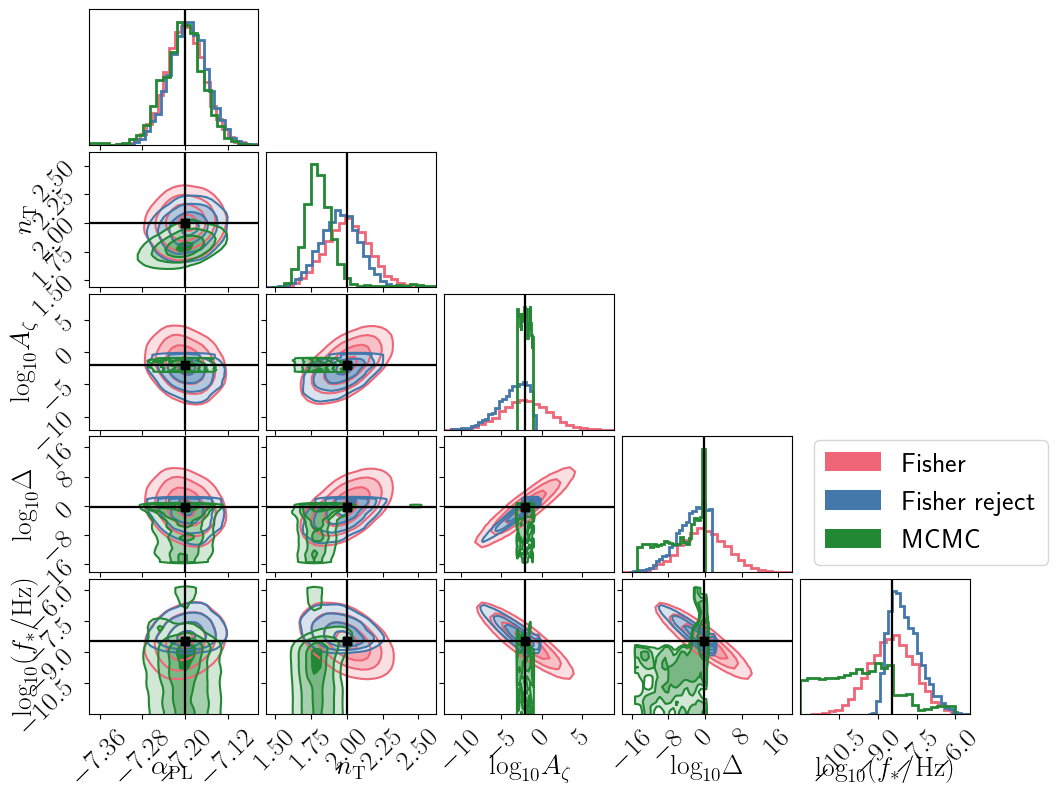

In [38]:
# Set the labels for the signal parameters
if not parameter_labels:
    parameter_labels = signal_model.parameter_labels

# Prepare input for the plotting function
datasets = [fisher_data, fisher_reject, MCMC_data]
weights = [
    np.ones(len_fisher_data),
    np.ones(len(fisher_reject)),
    np.ones(MCMC_data.shape[0]),  # type: ignore
]
smooth = [1.0, 1.0, 1.0]
ranges = np.array(fisher_ranges.T)
colors = [
    pf.my_colormap["red"],
    pf.my_colormap["blue"],
    pf.my_colormap["green"],
]

# Do the corner plot
pf.plot_corner(
    datasets,
    colors=colors,
    truths=signal_parameters,
    chain_labels=["Fisher", "Fisher reject", "MCMC"],
    weights=weights,
    smooth=smooth,
    labels=parameter_labels,
    # range=ranges,
    truth_color="black",
)